# Convex Optimization for Machine Learning & Computer Vision
## Week 6 Programming Exercise - Multinomial Logistic Regression
| Name  | Matriculation Number  | E-mail  |
| :------- | :----------------------- | :--------- |
| Akbar, Uzair   | 03697290 | [uzair.akbar@tum.de](mailto:uzair.akbar@tum.de) |

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
import os
import gzip
import shutil

In [0]:
# Toy data related

_TOY_DATA_CLUSTER_CENTERS = ((2, -4), (-3, 3), (3, 1), (-5, -2), (-4, -5))
_TOY_DATA_COLORS = ('g', 'r', 'b', 'm', 'y')


def get_toy_data(classes=5,
                 samples_per_class=500,
                 feature_dim=2,
                 noise_dim=100,
                 feature_sigma=1.0,
                 noise_sigma=3.0,
                 cluster_centers=_TOY_DATA_CLUSTER_CENTERS,
                 test_ratio=0.1,
                 visualize=True):
    num_samples = samples_per_class * classes
    total_dim = feature_dim + noise_dim + 1
    data = np.zeros((num_samples, total_dim))
    for j in range(classes):
        # generate useful features
        data[j*samples_per_class:(j+1)*samples_per_class, 0:feature_dim] = \
            np.array(cluster_centers[j]).reshape(1, feature_dim) + \
            np.random.randn(samples_per_class, feature_dim) * feature_sigma
        # generate random features
        data[j*samples_per_class:(j+1)*samples_per_class,
             feature_dim:total_dim-1] = \
            np.random.randn(samples_per_class, noise_dim) * noise_sigma
        # generate ground-truth labels
        data[j*samples_per_class:(j+1)*samples_per_class, total_dim-1] = \
            np.ones(samples_per_class) * j
    # shuffle data
    data = np.random.permutation(data)
    # Split data into training and test set
    sp_idx = num_samples - int(test_ratio * num_samples)
    train_data = data[:sp_idx, :]
    test_data = data[sp_idx:, :]
    # visualize if asked to
    if visualize:
        plt.figure('train_data')
        train_colors = [_TOY_DATA_COLORS[int(c)] for c in train_data[:, -1]]
        plt.scatter(train_data[:, 0], train_data[:, 1], c=train_colors)
        plt.figure('test_data')
        test_colors = [_TOY_DATA_COLORS[int(c)] for c in test_data[:, -1]]
        plt.scatter(test_data[:, 0], test_data[:, 1], c=test_colors)
        plt.show()
    return train_data, test_data, classes

In [0]:
# MNIST data related

MNIST_CLASSES = 10
_MNIST_URL_BASE = 'http://yann.lecun.com/exdb/mnist/'
_MNIST_FILES = {'train_image': 'train-images-idx3-ubyte',
                'train_label': 'train-labels-idx1-ubyte',
                'test_image': 't10k-images-idx3-ubyte',
                'test_label': 't10k-labels-idx1-ubyte'}


def download_unzip_gz(from_url, save_as):
    print('Downloading from {}'.format(from_url))
    with request.urlopen(from_url) as src, open(save_as, 'wb') as dst:
        shutil.copyfileobj(gzip.GzipFile(fileobj=src), dst)
    print('Saved as {}'.format(save_as))


def load_MNIST_images(from_file):
    with open(from_file, 'rb') as content:
        return np.frombuffer(content.read(), np.uint8, offset=16
                             ).reshape(-1, 28*28)


def load_MNIST_labels(from_file):
    with open(from_file, 'rb') as content:
        return np.frombuffer(content.read(), np.uint8, offset=8).reshape(-1, 1)


def visualize_MNIST_data(data, rows=6, cols=10):
    out = np.zeros((28 * rows, 28 * cols))
    for r in range(rows):
        for c in range(cols):
            out[r*28:(r+1)*28, c*28:(c+1)*28] = \
                data[r+rows*c, :-1].reshape(28, 28)
    plt.figure('MNIST training image examples')
    plt.imshow(out / 255., cmap='gray')
    plt.show()


def get_MNIST_data(save_dir='.', visualize=True):
    # download MNIST data if not present already
    for filename in _MNIST_FILES.values():
        filepath = os.path.join(save_dir, filename)
        if os.path.exists(filepath):
            print('Found {}'.format(filepath))
        else:
            download_unzip_gz(_MNIST_URL_BASE+filename+'.gz', filepath)
    # load MNIST data
    train_image = load_MNIST_images(
            os.path.join(save_dir, _MNIST_FILES['train_image']))
    train_label = load_MNIST_labels(
            os.path.join(save_dir, _MNIST_FILES['train_label']))
    train_data = np.concatenate((train_image, train_label),
                                axis=1).astype(np.float64)
    test_image = load_MNIST_images(
            os.path.join(save_dir, _MNIST_FILES['test_image']))
    test_label = load_MNIST_labels(
            os.path.join(save_dir, _MNIST_FILES['test_label']))
    test_data = np.concatenate((test_image, test_label),
                               axis=1).astype(np.float64)
    # visualize examples if required
    visualize_MNIST_data(train_data)
    return train_data, test_data, MNIST_CLASSES

In [0]:
# optimization related

def softmax(z, dim):
    ez = np.exp(z - np.max(z, dim, keepdims=True))
    return ez / np.sum(ez, dim, keepdims=True)

def log_softmax(z, dim):
    dz = z - np.max(z, dim, keepdims=True)
    return dz - np.log(np.sum(np.exp(dz), dim, keepdims=True))

def classifier(X, W, b):
    return X @ W + b

def score(X, W, b):
    return softmax(classifier(X, W, b), 1)

def average_loss(X, y, W, b):
    y = y.astype(np.long)
    return np.mean(-log_softmax(classifier(X, W, b), 1)[np.arange(len(y)), y])

# the differentiable objective
def objective_diff(X, y, W, b, lambda1, lambda2):
    return average_loss(X, y, W, b) + 0.5 * lambda2 * np.sum(np.square(b)) + \
        0.5 * lambda1 * np.sum(np.square(W))

# the non-differentiable objective
def objective_nondiff(X, y, W, b, lambda1, lambda2):
    return average_loss(X, y, W, b) + 0.5 * lambda2 * np.sum(np.square(b)) + \
        0.5 * lambda1 * np.sum(np.sqrt(np.sum(np.square(W), 1)))

It is [straighhtforward to show](https://math.stackexchange.com/questions/1428344/what-is-the-derivation-of-the-derivative-of-softmax-regression-or-multinomial-l) that the gradient of the log-softmax loss can be re-written in vector form as the following.

$
\begin{align}
\nabla_{\mathbf{W}}\,\mathcal{l}(\mathbf{W}, \mathbf{b}, \mathbf{x}, \mathbf{y}) & = & -\frac{1}{N}\mathbf{x}^T\Big( \mathbf{y} - \sigma(\mathbf{W}^T\mathbf{x} + \mathbf{b})\Big)\\
\nabla_{\mathbf{b}}\,\mathcal{l}(\mathbf{W}, \mathbf{b}, \mathbf{x}, \mathbf{y}) & = & -\frac{1}{N} \Big( \mathbf{y} - \sigma(\mathbf{W}^T\mathbf{x} + \mathbf{b})\Big).
\end{align}
$

Where $\mathbf{y} \in \{0, 1\}^K$ is a one-hot vector with $y_k = 1$ for ground-truth class $k$ and $\sigma(.)$ is the soft-max function.


In [0]:
# gradient related

# one hot representation
def one_hot(t, c):
    return np.eye(c)[t.astype(np.int)]

# TODO: gradients of the average logsoftmax loss w.r.t. W
def grad_W_avgloss(X, score, y):
    return np.matmul(X.T, (score - one_hot(y, score.shape[1]))) / X.shape[0]

# TODO: gradients of the average logsoftmax loss w.r.t. b
# You can use e.g. scipy.optimize.minimize to compare your result for the
# differentiable objective objective_diff.
def grad_b_avgloss(score, y):
    return np.mean(score - one_hot(y, score.shape[1]), axis=0)

# TODO: gradients of the square regularization term for W in objective_diff
def grad_W_sqreg(W, lambda1):
    return lambda1 * W

# TODO: gradients of the square regularization term for b in both objectives
def grad_b_sqreg(b, lambda2):
    return lambda2 * b

For $J(\mathbf{X})=\frac{\lambda_1}{2}\left\Vert{\mathbf{X}}\right\Vert_{1, 2}$, the definition of the proximal operator gives


$
\begin{align*}
\because\; & \text{prox}_{\tau J}\big(\mathbf{X}\big) & :=\; & \arg \min_\mathbf{Y} J(\mathbf{Y}) + \frac{1}{2\tau}\left\Vert \mathbf{Y} - \mathbf{X} \right\Vert^2_2 & & \\
\Rightarrow & & =\; & \arg \min_\mathbf{Y} \frac{\lambda_1}{2}\left\Vert{\mathbf{Y}}\right\Vert_{1, 2} + \frac{1}{2\tau}\left\Vert \mathbf{Y} - \mathbf{X} \right\Vert^2_2 & & \\
\Rightarrow & & =\; & \arg \min_\mathbf{Y} \frac{\lambda_1}{2}\Big(\left\Vert{\mathbf{Y}}\right\Vert_{1, 2} + \frac{1}{2}\frac{2}{\tau\lambda_1}\left\Vert \mathbf{Y} - \mathbf{X} \right\Vert^2_2\Big) & & \\
\Rightarrow & & =\; & \arg \min_\mathbf{Y}\left\Vert{\mathbf{Y}}\right\Vert_{1, 2} + \frac{1}{2\tau'}\left\Vert \mathbf{Y} - \mathbf{X} \right\Vert^2_2\;&,\;\;\;\; & \tau'=\frac{\tau\lambda_1}{2}\\
\therefore\; & \text{prox}_{\tau J}\big(\mathbf{X}\big) & =\; & \text{prox}_{\tau' \left\Vert . \right\Vert_{1, 2}}\big(\mathbf{X}\big)\;&,\;\;\;\; & \tau'=\frac{\tau\lambda_1}{2}
\end{align*}
$

As we already know from [theoretical exercise 6.4](https://github.com/uzairakbar/convex-optimization/blob/master/exercises/week6/solutionSubmission6.pdf), the proximal operator for the $l_{1, 2}$-norm is given as:

$
{prox}_{\tau' \left\Vert . \right\Vert_{1, 2}}\big(\mathbf{X}\big) = \Big\{ \mathbf{Y} \in \mathbf{R}^{m\times n} \;\Big|\; \mathbf{Y}_i=\begin{cases}
\mathbf{0}\; & , & \;\left\Vert \mathbf{X}_i \right\Vert_2 \leq \tau'\\
\mathbf{X}_i - \tau'\frac{\mathbf{X}_i}{\left\Vert \mathbf{X}_i \right\Vert_2}\; & , & \;\left\Vert \mathbf{X}_i \right\Vert_2 \gt \tau'
\end{cases}\Big\}
$

Saved as ./train-images-idx3-ubyte
Saved as ./train-labels-idx1-ubyte
Saved as ./t10k-images-idx3-ubyte
Saved as ./t10k-labels-idx1-ubyte


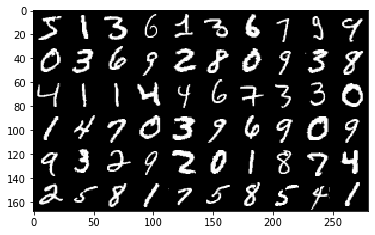

iteration=0	 |	 obj=12.60	 |	 train=89.10	 |	 test=88.41
iteration=500	 |	 obj=1.39	 |	 train=10.29	 |	 test=9.92
iteration=1000	 |	 obj=0.86	 |	 train=11.89	 |	 test=11.26
iteration=1500	 |	 obj=0.86	 |	 train=11.98	 |	 test=11.17
iteration=2000	 |	 obj=0.85	 |	 train=12.01	 |	 test=11.16
iteration=2500	 |	 obj=0.85	 |	 train=12.01	 |	 test=11.17
iteration=3000	 |	 obj=0.85	 |	 train=12.04	 |	 test=11.18
iteration=3500	 |	 obj=0.85	 |	 train=12.05	 |	 test=11.17
iteration=4000	 |	 obj=0.85	 |	 train=12.05	 |	 test=11.18
iteration=4500	 |	 obj=0.85	 |	 train=12.04	 |	 test=11.20
iteration=5000	 |	 obj=0.85	 |	 train=12.05	 |	 test=11.18
iteration=5500	 |	 obj=0.85	 |	 train=12.06	 |	 test=11.18


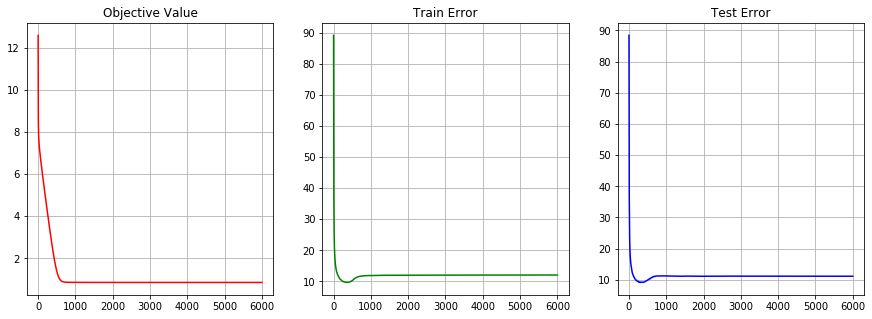

In [6]:
np.random.seed(43)  # manual random seed for reproducible results
use_mnist = True  # REMARK: set to true once your code works on toy data

# get data
if use_mnist:
    train_data, test_data, classes = get_MNIST_data(save_dir='.',
                                                    visualize=True)
else:
    train_data, test_data, classes = get_toy_data(visualize=True)
X, X_test = train_data[:, :-1], test_data[:, :-1]
feature_dim = X.shape[1]
y, y_test = train_data[:, -1], test_data[:, -1]

# Normalize input data
X, X_test = X / np.max(X), X_test / np.max(X_test)

# initialize parameters to be trained
W = np.random.rand(feature_dim, classes)
b = np.zeros((1, classes))

# TODO(optional): Do derivative check (for debugging only).
# You can use scipy.optimize.grad_check on objective_diff to verify the 4
# gradient functions you have implemented.
pass

# define optimization parameters
lambda1, lambda2 = 0.01, 0.02
max_iter = 6000
if use_mnist:
    tau = 0.7
else:
    tau = 1 / (np.mean(np.sum(np.square(X), axis=1)) + lambda1)
threshold = 1e-12

# define lists that should be filled up in the following updates
obj_val = []
train_error = []
test_error = []
# perform proximal gradient iterations
for i in range(max_iter):
    # TODO: implement proximal gradient here...
    ########################################################################
    # calculate the train and test score
    score_train, score_test = score(X, W, b), score(X_test, W, b)

    # calculate the train and test prediction
    prediction_train, prediction_test = (np.argmax(score_train, axis=1), 
                                         np.argmax(score_test, axis=1))

    # calculate objective value, test error and training error
    obj_val.append(objective_nondiff(X, y, W, b, lambda1, lambda2))
    train_error.append(np.mean((prediction_train != y
                                ).astype(np.float))*100.)
    test_error.append(np.mean((prediction_test != y_test
                                ).astype(np.float))*100.)
    
    # do gradient descent iteration on the differentiable objective
    W = W - tau * grad_W_avgloss(X, score_train, y)
    b = b - tau * (grad_b_avgloss(score_train, y) + grad_b_sqreg(b, lambda2))

    # apply proximal operator of 1,2-norm to W
    row_l2_norm = np.sqrt(np.sum(np.square(W), axis=1))
    tau_ = tau*lambda1/2
    W[row_l2_norm <= tau_, :] = 0
    W[row_l2_norm > tau_, :] = W[row_l2_norm > tau_, :] - \
            tau_ * W[row_l2_norm > tau_, :] / row_l2_norm[row_l2_norm > tau_, np.newaxis]
    
    # display current results every 500 iterations
    if i%500 == 0:
        print('iteration={}\t |\t obj={:.2f}\t |\t train={:.2f}\t |\t test={:.2f}'.format(
                i, obj_val[-1], train_error[-1], test_error[-1]))
    ########################################################################
    # evalualte stopping criterion
    if i > 0 and obj_val[i-1] - obj_val[i] < threshold:
        break

# Plot objective value, train / test loss
fig = plt.figure('Results')
fig.set_size_inches(15, 5)
ax = fig.add_subplot(1, 3, 1)
ax.plot(range(len(obj_val)), obj_val, 'r')
ax.set_title("Objective Value")
ax.grid()
ax = fig.add_subplot(1, 3, 2)
ax.plot(range(len(train_error)), train_error, 'g')
ax.set_title("Train Error")
ax.grid()
ax = fig.add_subplot(1, 3, 3)
ax.plot(range(len(test_error)), test_error, 'b')
ax.set_title("Test Error")
ax.grid()
plt.show()
# plot classifier for toy data case
if not use_mnist:
    s = 0.1
    x1Grid, x2Grid = np.meshgrid(np.arange(-4, 4, s), np.arange(-4, 4, s))
    xGrid = np.stack((x1Grid.flatten(), x2Grid.flatten()), axis=1)
    scores_train = classifier(xGrid, W[0:2, :], b)
    plt.figure('classifier')
    test_colors = [_TOY_DATA_COLORS[int(c)] for c in test_data[:, -1]]
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_colors)
    for c in range(classes):
        color = _TOY_DATA_COLORS[c]
        plt.contour(x1Grid, x2Grid,
                    scores_train[:, c].reshape(x1Grid.shape),
                    levels=1, colors=color)
    plt.show()

The useless features are assigned low weights in $\mathbf{W}^\ast$, which are the background pixels that occupy most of the area in the image (therefore, the closer a pixel is to the edge of the image, the higher the likelihood it belongs to the background and subsequently the edge pixels/features will be assigned low weights).

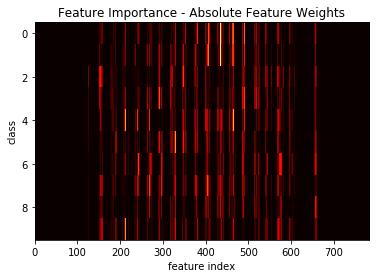

In [7]:
# visualization of feature importance
plt.imshow(np.abs(W.T), cmap='hot', interpolation='nearest', aspect='auto')
plt.xlabel("feature index")
plt.ylabel("class")
plt.title("Feature Importance - Absolute Feature Weights")
plt.show()

Therefore, $l_{1, 2}$ norm performs better because it promotes sparsity, and useless features are ignored in classification. In contrast, $l_2$ norm promotes dense weights, which encourages the model to use irrelevant features despite no predictive power in terms of labels.

***